In [18]:
import re
import umap
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

sys.path.append('../src')
from config import *
from utils import *
from preprocessing import *

In [19]:
# Load the dataset
data = pd.read_csv(f'../{data_file}')
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = data[label_names]
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:

# Number of samples in train dataset
num_samples = len(data)
print(f"Number of samples in the train dataset: {num_samples}")

Number of samples in the train dataset: 159571


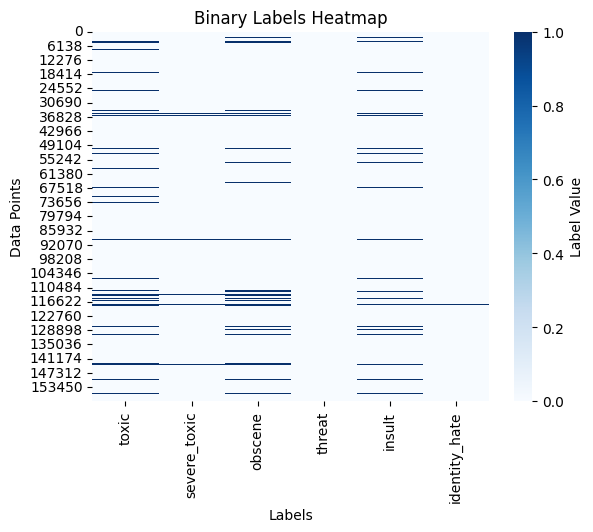

In [21]:
sns.heatmap(y, cmap='Blues', cbar_kws={'label': 'Label Value'})
plt.title('Binary Labels Heatmap')
plt.xlabel('Labels')
plt.ylabel('Data Points')
plt.show()  

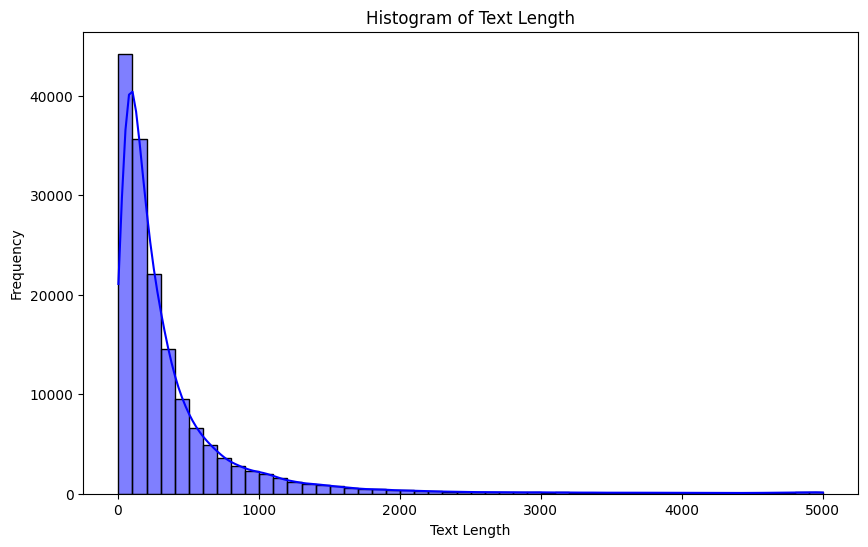

In [22]:
# Histogram of the length of samples
data['text_length'] = data['comment_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Count emojies
def count_emojis(text):
    emoji_pattern = re.compile(r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\u2600-\u26FF\u2700-\u27BF\U0001F004]+')
    emojis = re.findall(emoji_pattern, text)
    return emojis

# Count the frequency of emojis in each comment
data['emoji_count'] = data['comment_text'].apply(lambda x: len(count_emojis(x)))

# Calculate the percentile of samples with emojis
total_samples = len(data)
samples_with_emojis = len(data[data['emoji_count'] > 0])
percentile_with_emojis = (samples_with_emojis / total_samples) * 100

print(f"Percentile of samples with emojis: {percentile_with_emojis:.2f}%")

Percentile of samples with emojis: 0.89%


In [24]:
# Sample stats: number of words, chars, symbols, capital letters, etc. in each sample
data['num_words'] = data['comment_text'].apply(lambda x: len(str(x).split()))
data['num_chars'] = data['comment_text'].apply(len)
data['num_symbols'] = data['comment_text'].apply(lambda x: sum(c.isalpha() or c.isspace() for c in x))
data['num_capital_letters'] = data['comment_text'].apply(lambda x: sum(c.isupper() for c in x))
data_stats = data[['num_words', 'num_chars', 'num_symbols', 'num_capital_letters']]
print("Sample Stats:")
print(data_stats.describe())

Sample Stats:
           num_words      num_chars    num_symbols  num_capital_letters
count  159571.000000  159571.000000  159571.000000        159571.000000
mean       67.273527     394.073221     374.663874            17.159628
std        99.230702     590.720282     563.785623            96.528103
min         1.000000       6.000000       0.000000             0.000000
25%        17.000000      96.000000      89.000000             3.000000
50%        36.000000     205.000000     194.000000             7.000000
75%        75.000000     435.000000     415.000000            15.000000
max      1411.000000    5000.000000    5000.000000          4960.000000


In [25]:
# Filter special symbols, clean sample's text
data['cleaned_text'] = data['comment_text'].apply(clean_text)

In [26]:
# Convert text to vectors using TfIdfVectorizer
X = data['cleaned_text']
X, vectorizer = fit_vectorize(X)

n_features = X.shape[1]
print(f"Length of tfidf vectors: {n_features}")

Length of tfidf vectors: 182231


In [27]:
# Imbalance
samples_per_label = y.sum(axis=0)

# Imbalance ratio for each label
imbalance_ratios_per_label = samples_per_label / len(y)
print("Samples Ratio for Each Label:")
print(imbalance_ratios_per_label)

# Overall imbalance ratio
overall_imbalance_ratio = imbalance_ratios_per_label.max() / imbalance_ratios_per_label.min()
print("\nOverall Imbalance Ratio:", overall_imbalance_ratio)

Samples Ratio for Each Label:
toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

Overall Imbalance Ratio: 31.99581589958159


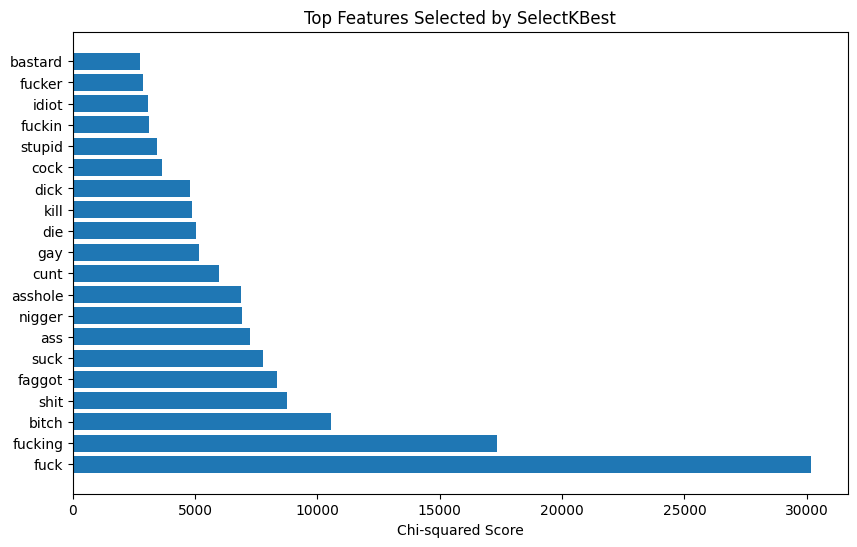

In [28]:
# Select relevant features
if use_feature_selection:
    X, selector, selected_feature_names, selected_feature_scores = fit_select_features(
        X,
        y,
        vectorizer.get_feature_names_out(),
        features_to_keep=features_to_keep
    )
    
    # Plot the top N features
    top_n = 20  # Change this to the desired number of top features to visualize
    plt.figure(figsize=(10, 6))
    plt.barh(selected_feature_names[:top_n], selected_feature_scores[:top_n])
    plt.xlabel('Chi-squared Score')
    plt.title('Top Features Selected by SelectKBest')
    plt.show()

In [31]:
# Reduce dimentions
# X_reduced = reduce_dimentions(X, f'../{pca_model}')

# Scale
X_tfidf = scale(X, f'../{scaler_model}')

# KMeans
# X_tfidf = predict_kmeans(X_tfidf, f'../{kmeans_model}')

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [33]:
# 2d PCA
n_components_pca = 2
pca = PCA(n_components=n_components_pca)

# Sample data to fit into ram
num_rows = X_tfidf.shape[0]
rows_to_remove = int(0.8 * X_tfidf.shape[0])

# Generate random indices of rows to keep
rows_to_keep = np.random.choice(num_rows, num_rows - rows_to_remove, replace=False)

# Create a new sparse matrix with only the randomly selected rows
X_tfidf_sampled = X_tfidf[rows_to_keep]

pca_result_2d = pca.fit_transform(X_tfidf_sampled)
print("Explained Variance Ratios:", pca.explained_variance_ratio_)

Explained Variance Ratios: [0.16858381 0.00690666]


C:\Users\tmyro\AppData\Local\Temp\ipykernel_12792\3763979532.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(pca_result_2d[:, 0], pca_result_2d[:, 1], c='blue', cmap='viridis')


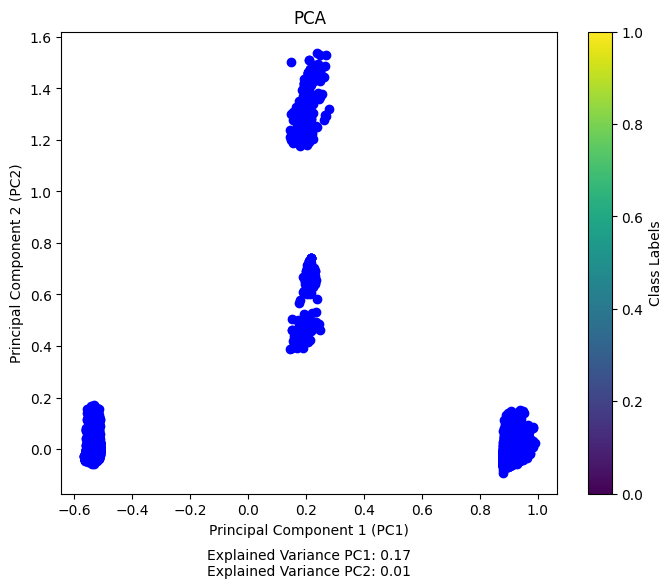

In [36]:
# Plot the principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result_2d[:, 0], pca_result_2d[:, 1], c='blue', cmap='viridis')

# Add colorbar to show class labels
plt.colorbar(scatter, label='Class Labels')

# Set labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA')

# Display the explained variance
explained_variance_ratio = pca.explained_variance_ratio_
plt.text(0.5, -0.15, f'Explained Variance PC1: {explained_variance_ratio[0]:.2f}\nExplained Variance PC2: {explained_variance_ratio[1]:.2f}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

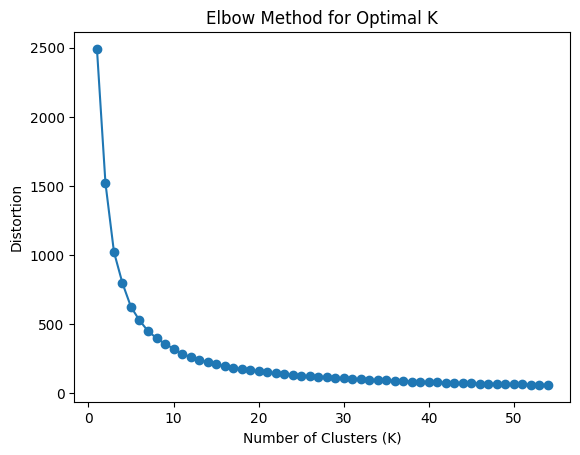

In [ ]:
# Elbow Method
plot_kmeans(X, )